# Deep Gaussian Markov Random Fields

Home-made reimplementation in JAX. Original code can be found [here](https://bitbucket.org/psiden/deepgmrf/src/master/).

In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

from functools import partial
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import optax
from jax_tqdm import scan_tqdm
import copy
import equinox as eqx


key = jax.random.PRNGKey(0)

In [2]:
try:
    gpu_device = jax.devices('gpu')[0]
except:
    raise RuntimeError("No GPU found")
cpu_device = jax.devices('cpu')[0]
print(cpu_device, gpu_device)

TFRT_CPU_0 cuda:0


## First create some observations
We sample a GMRF with Cholesky sampling

In [3]:
H = 80
W = 80
r = 10


In [4]:
def euclidean_dist(x1, x2, y1, y2):
    return jnp.sqrt((x1 - x2) ** 2 +
                   (y1 - y2) ** 2)

def corr_exp(xy1, xy2, lx, ly, r):
    x1 = xy1 // lx
    y1 = xy1 % lx
    x2 = xy2 // lx
    y2 = xy2 % lx
    return jnp.exp(-euclidean_dist(x1, x2, y1, y2) / r)
    
def fill_diagonal(a, val):
    assert a.ndim >= 2
    i, j = jnp.diag_indices(min(a.shape[-2:]))
    return a.at[..., i, j].set(val)

def cholesky_sampling_gaussian_field(r, source_term, lx, ly):
    '''
    Given the covariance matrix R ((lx*ly,lx*ly)) simulate a
    gaussian random field Y

    The vmapping enables to fill the big covariance matrix quickly
    '''
    iterating = jnp.meshgrid(jnp.arange(lx * ly), jnp.arange(lx * ly))
    iterating = jnp.array([iterating[0].flatten(), iterating[1].flatten()])
    v_ = jax.jit(jax.vmap(corr_exp, (0, 0, None, None, None)))
    cov_mat = v_(iterating[0, :], iterating[1, :], lx, ly, r)
    cov_mat = cov_mat.reshape((lx * ly, lx * ly))
    cov_mat = fill_diagonal(cov_mat, 1.)
    B = jnp.linalg.cholesky(cov_mat)
    

    Y = B @ source_term
    
    Y = Y.reshape((lx, ly))

    return Y

key, subkey = jax.random.split(key)
source_term = jax.random.normal(subkey, shape=(H * W,))

with jax.default_device(cpu_device):
    x_ori = cholesky_sampling_gaussian_field(r, source_term.flatten(), H, W)

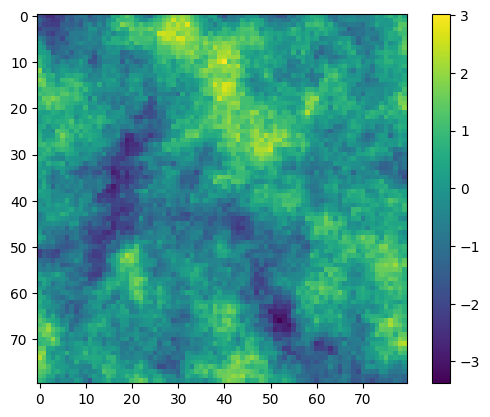

In [5]:
plt.imshow(x_ori)
plt.colorbar()
plt.show()

Add noise over the observations

In [6]:
key, subkey = jax.random.split(key)
true_sigma_noise = 1.
y = x_ori + jax.random.normal(subkey, x_ori.shape) * true_sigma_noise
M = H * W # no pixel are hidden in the observations

In [7]:
# y = x_ori.at[20:40, 40:60].set(jnp.nan)
# M = H * W - (20 * 20)

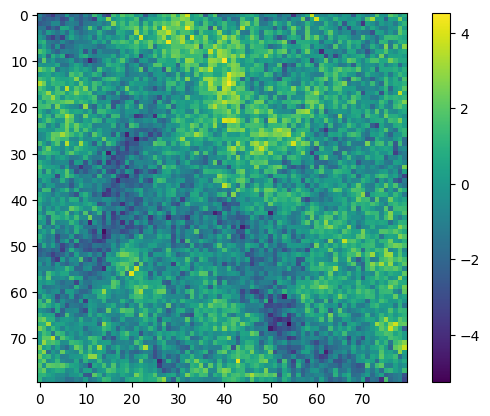

In [8]:
plt.imshow(y)
plt.colorbar()
plt.show()

## Define the DGMRF components

In [9]:
L = 1
Nq = 1

In [10]:
y = y.flatten()

In [11]:
class G(eqx.Module):
    """
    Define one convolution of a DGMRF parametrization
    """
    conv_params: jax.Array
    bias_params: jax.Array
    H: int = eqx.field(static=True)
    W: int = eqx.field(static=True)

    def __init__(self, conv_params, bias_params, H, W):
        self.conv_params = conv_params
        self.bias_params = bias_params
        self.H = H
        self.W = W

    def __call__(self, z, transpose=False):
        """
        Return z = G_lz_l-1 + b, i.e., apply one convolution
        """
        a = G.conv_params_transform(self.conv_params)
        w = jnp.array([[0, a[2], 0], [a[1], a[0], a[3]], [0, a[4], 0]])
        if transpose:
            w = w.T
        Gz = jax.scipy.signal.convolve(z, w, mode="same")
        return Gz + self.bias_params

    def efficient_logdet_G_l(self):
        """
        Efficient computation of the determinant of a G_l (Proposition 2)
        """
        a = G.conv_params_transform_light(self.conv_params)
        def scan_fun(carry, ij):
            i, j = jnp.unravel_index(ij, (self.H, self.W))
            log_det_ij = jnp.log(
                jnp.abs(
                    a[0] + 2 * jnp.sqrt(a[2]) *
                    jnp.cos(jnp.pi * i / (self.H + 1)) + 2 * jnp.sqrt(a[1]) *
                    jnp.cos(jnp.pi * j / (self.W + 1))
                )
            )
            return (), log_det_ij
    
        _, accu_log_det_ij = jax.lax.scan(
            scan_fun,
            (),
            jnp.arange(self.H * self.W)
        )
    
        return jnp.sum(accu_log_det_ij)

    @staticmethod
    def conv_params_transform(conv_params):
        a1 = jax.nn.softplus(conv_params[0]) + jax.nn.softplus(conv_params[1])
        a2a4 = (jax.nn.softplus(conv_params[0]) * jax.nn.tanh(conv_params[2]) / 2) ** 2
        a4_a2 = jnp.exp(conv_params[3])
        a2 = jnp.sqrt(a2a4 / a4_a2)
        a4 = jnp.sqrt(a2a4 * a4_a2)
        a3a5 = (jax.nn.softplus(conv_params[1]) * jax.nn.tanh(conv_params[4]) / 2) ** 2
        a5_a3 = jnp.exp(conv_params[5])
        a3 = jnp.sqrt(a3a5 / a5_a3)
        a5 = jnp.sqrt(a3a5 * a5_a3)
        return jnp.array([a1, a2, a3, a4, a5])

    @staticmethod
    def conv_params_transform_light(conv_params):
        a1 = jax.nn.softplus(conv_params[0]) + jax.nn.softplus(conv_params[1])
        a2a4 = (jax.nn.softplus(conv_params[0]) * jax.nn.tanh(conv_params[2]) / 2) ** 2
        a3a5 = (jax.nn.softplus(conv_params[1]) * jax.nn.tanh(conv_params[4]) / 2) ** 2
        return jnp.array([a1, a2a4, a3a5])

In [12]:
c = eqx.nn.Conv(num_spatial_dims=2, in_channels=1, out_channels=1, kernel_size=3, key=key)
print(c.weight.shape)

(1, 1, 3, 3)


In [13]:
class DGMRF(eqx.Module):
    """
    Define a complete DGMRF parametrization
    """
    key: jax.Array
    nb_layers: int = eqx.field(static=True)
    g_conv: list
    a_params: list
    H: int = eqx.field(static=True)
    W: int = eqx.field(static=True)
    
    def __init__(self, key, nb_layers, H, W):#, conv_params_list=None, bias_params_list=None):
        self.key = key
        self.nb_layers = nb_layers
        self.g_conv = []
        self.a_params = []
        self.H = H
        self.W = W
        
        for l in range(self.nb_layers):
            self.key, subkey1, subkey2, subkey3 = jax.random.split(self.key, 4)
            self.g_conv.append(
                eqx.nn.Conv(
                    num_spatial_dims=2,
                    in_channels=1,
                    out_channels=1,
                    kernel_size=3,
                    stride=1,
                    padding=int((3-1)/2), #(K-S)/2 to get padding="same"
                    key=subkey1
                )
            )
            self.g_conv[l] = eqx.tree_at(lambda x:x.weight, self.g_conv[l], jnp.zeros_like(self.g_conv[l].weight))

            self.a_params.append(
                jax.random.uniform(subkey2, (5,), minval=-1, maxval=1)
            )                             
            # if conv_params_list is None or bias_params_list is None:
            #     self.key, subkey1, subkey2 = jax.random.split(self.key, 3)
            #     self.g_conv.append(
            #         G(
            #             jax.random.uniform(subkey1, (5,), minval=-1, maxval=1),
            #             jax.random.normal(subkey2, (1,)) * 0.01 ,
            #             H,
            #             W
            #         )
            #     )
            # else:
            #     self.g_conv.append(G(conv_params_list[l], bias_params_list[l], H, W))

    def __call__(self, x, transpose=False):
        """
        Return the composition of g = gLgL-1...g1(z0) with z0 = x
        """
        z_l_1 = x
        for l in range(self.nb_layers):
            if transpose:
                self.g_conv[l] = eqx.tree_at(lambda x:x.weight, self.g_conv[l],
                                         DGMRF.conv_params_transform(self.g_conv[l].weight, self.a_params[l]).T
                                        )
            else:
                self.g_conv[l] = eqx.tree_at(lambda x:x.weight, self.g_conv[l],
                                             DGMRF.conv_params_transform(self.g_conv[l].weight, self.a_params[l])
                                            )
            print(z_l_1[None].shape)
            z_l_1 = self.g_conv[l](z_l_1[None]).squeeze()
        return z_l_1

    def log_det(self):
        log_det = 0 
        for l in range(self.nb_layers):
            log_det += DGMRF.efficient_logdet_G_l(self.a_params[l], H, W)
        return log_det

    @staticmethod
    def efficient_logdet_G_l(a_params, H, W):
        """
        Efficient computation of the determinant of a G_l (Proposition 2)
        """
        a = DGMRF.conv_params_transform_light(a_params)
        def scan_fun(carry, ij):
            i, j = jnp.unravel_index(ij, (H, W))
            log_det_ij = jnp.log(
                jnp.abs(
                    a[0] + 2 * jnp.sqrt(a[1]) *
                    jnp.cos(jnp.pi * i / (H + 1)) + 2 * jnp.sqrt(a[2]) *
                    jnp.cos(jnp.pi * j / (W + 1))
                )
            )
            return (), log_det_ij
    
        _, accu_log_det_ij = jax.lax.scan(
            scan_fun,
            (),
            jnp.arange(H * W)
        )
    
        return jnp.sum(accu_log_det_ij)

    @staticmethod
    def conv_params_transform(conv_params, a_params):
        a1 = jax.nn.softplus(a_params[0]) + jax.nn.softplus(a_params[1])
        a2a4 = (jax.nn.softplus(a_params[0]) * jax.nn.tanh(a_params[2]) / 2) ** 2
        a4_a2 = jnp.exp(a_params[3])
        a2 = jnp.sqrt(a2a4 / a4_a2)
        a4 = jnp.sqrt(a2a4 * a4_a2)
        a3a5 = (jax.nn.softplus(a_params[1]) * jax.nn.tanh(a_params[4]) / 2) ** 2
        a5_a3 = jnp.exp(a_params[5])
        a3 = jnp.sqrt(a3a5 / a5_a3)
        a5 = jnp.sqrt(a3a5 * a5_a3)

        conv_params.at[0, 0, 0, 1].set(a3)
        conv_params.at[0, 0, 1, 0].set(a1)
        conv_params.at[0, 0, 1, 1].set(a2)
        conv_params.at[0, 0, 1, 2].set(a4)
        conv_params.at[0, 0, 2, 1].set(a5)

        return conv_params #jnp.array([[0, a3, 0], [a2, a1, a4], [0, a5, 0]])[None, None]

    @staticmethod
    def conv_params_transform_light(a_params):
        a1 = jax.nn.softplus(a_params[0]) + jax.nn.softplus(a_params[1])
        a2a4 = (jax.nn.softplus(a_params[0]) * jax.nn.tanh(a_params[2]) / 2) ** 2
        a3a5 = (jax.nn.softplus(a_params[1]) * jax.nn.tanh(a_params[4]) / 2) ** 2
        return jnp.array([a1, a2a4, a3a5])

In [14]:
key, subkey = jax.random.split(key, 2)
dgmrf = DGMRF(subkey, L, H, W)
dgmrf_params, dgmrf_static = eqx.partition(dgmrf, lambda x:eqx.is_inexact_array(x) and len(x.shape) < 4) # and not eqx.is_exact because the layer would consider self.key as a parameter!
print(dgmrf_params, dgmrf_static)

DGMRF(
  key=None,
  nb_layers=1,
  g_conv=[
    Conv(
      num_spatial_dims=2,
      weight=None,
      bias=f32[1,1,1],
      in_channels=1,
      out_channels=1,
      kernel_size=(3, 3),
      stride=(1, 1),
      padding=((1, 1), (1, 1)),
      dilation=(1, 1),
      groups=1,
      use_bias=True
    )
  ],
  a_params=[f32[5]],
  H=80,
  W=80
) DGMRF(
  key=u32[2],
  nb_layers=1,
  g_conv=[
    Conv(
      num_spatial_dims=2,
      weight=f32[1,1,3,3],
      bias=None,
      in_channels=1,
      out_channels=1,
      kernel_size=(3, 3),
      stride=(1, 1),
      padding=((1, 1), (1, 1)),
      dilation=(1, 1),
      groups=1,
      use_bias=True
    )
  ],
  a_params=[None],
  H=80,
  W=80
)


## Variational inference to compute model parameters

In [15]:
def elbo(params, static, key):
    
    dgmrf = eqx.combine(params["dgmrf"], static["dgmrf"])

    # Some reparametrizations to avoid numerical errors
    S_phi = jnp.exp(params["log_S_phi"])
    sigma = jnp.exp(params["log_sigma"])
    
    def scan_Nq(carry, nq):
        key = carry[0]
        key, subkey = jax.random.split(key, 2)
        eps = jax.random.normal(subkey, (H * W,))
        xi = params["nu_phi"] + jnp.sqrt(S_phi) * eps

        g_xi = dgmrf(xi.reshape((H, W))).flatten()
        res = (g_xi.T @ g_xi + 1 / (sigma ** 2) * (y - xi).T @ (y - xi))

        return (key,), res

    _, accu_mcmc = jax.lax.scan(
        scan_Nq,
        (key,),
        jnp.arange(Nq)
    )
    res_mcmc = jnp.mean(accu_mcmc)

    log_det_S_phi = jnp.sum(params["log_S_phi"])
    log_det_G_theta = dgmrf.log_det()
    log_sigma = params["log_sigma"]

    #jax.debug.print("{x}", x=(-log_det_S_phi, log_sigma,-log_det_G_theta, res_mcmc))
    # ELBO divided by H * W as stated in the supp material
    elbo = 1 / (H * W) *  (0.5 * log_det_S_phi - M * log_sigma
             + log_det_G_theta
            - 0.5 * res_mcmc)
    # Note that we return -elbo
    return -elbo

The initial values of the mean and std for the variational distribution are given lines 572 and 573 of the orignal code.

In [16]:
key, subkey1, subkey2 = jax.random.split(key, 3)
params_init = {
    "dgmrf":dgmrf_params,
    "log_sigma":jnp.log(true_sigma_noise),
    "nu_phi":y, #jnp.ones((H * W,)) * jax.random.uniform(subkey1, (H*W,), minval=-3, maxval=3), # * 0.3,
    "log_S_phi":jax.nn.softplus(jax.random.normal(subkey2, (H * W,)) * 0.01), # jnp.ones((H * W,)) * 1
}
static = {
    "dgmrf": dgmrf_static
}


In [17]:
n_iter = 500

tx = optax.multi_transform(
    {
     'dgmrf': optax.adam(1e-2), 'log_sigma': optax.adam(1e-2),
     'nu_phi': optax.adam(1e-2), 'log_S_phi': optax.adam(1e-2)},
    {'dgmrf':"dgmrf", 'log_sigma':'log_sigma', 'nu_phi':'nu_phi', 'log_S_phi':'log_S_phi'} # This what would be returned by the label_fn; i.e. this is the correct syntax when directly giving labels and when params is dict
)
opt_state = tx.init(params_init)

@scan_tqdm(n_iter)
def scan_fun(carry, i):
    key, params, opt_state = carry
    key, subkey = jax.random.split(key, 2)
    loss, grads = jax.value_and_grad(elbo)(params, static, subkey)
    # #jax.debug.print("{x}",x=(loss))
    updates, opt_state = tx.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return (key, params, opt_state), loss

key, subkey = jax.random.split(key, 2)
carry, loss_val = jax.lax.scan(
    scan_fun,
    (subkey, params_init, opt_state),
    jnp.arange(n_iter)
)
params_final = carry[1]

(1, 80, 80)


  0%|          | 0/500 [00:00<?, ?it/s]

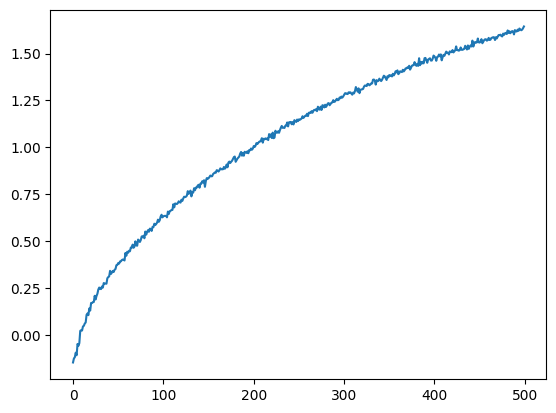

In [18]:
plt.plot(-loss_val)
plt.show()

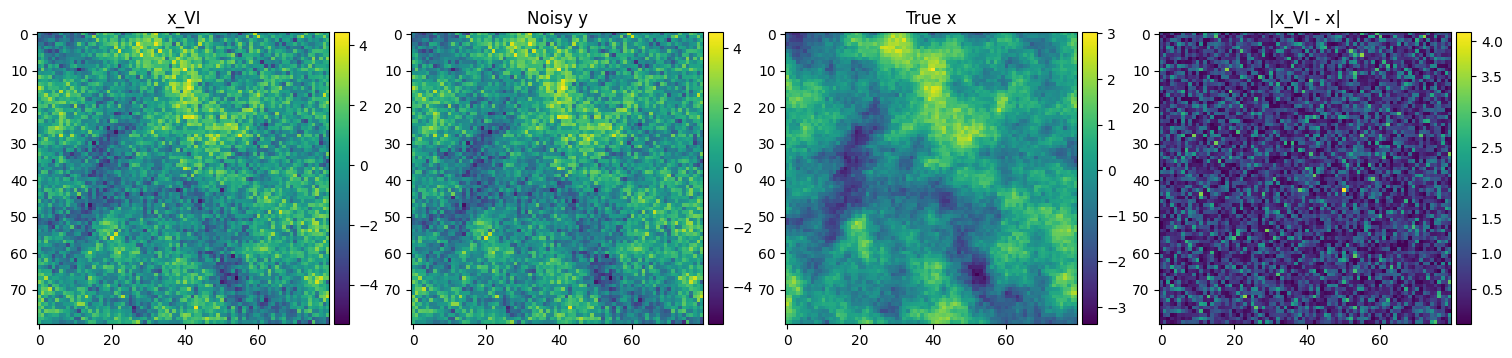

In [19]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(18.5, 10.5)

im = axes[0].imshow(params_final["nu_phi"].reshape(H, W))
axes[0].set_title("x_VI")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(y.reshape(H, W))
axes[1].set_title("Noisy y")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(x_ori)
axes[2].set_title("True x")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[3].imshow(jnp.abs(params_final["nu_phi"].reshape(H, W) - x_ori))
divider = make_axes_locatable(axes[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axes[3].set_title("|x_VI - x|")

plt.show()

## Posterior mean computation with conjugate gradient

We can give $\tilde{Q}$ as a function which tells how to compute $\tilde{Q}x$ that's what we'll do to avoid explicitely constructing $G$ and to be able to use the convolutions 

In [20]:
params_dgmrf_final = copy.deepcopy(params_final["dgmrf"])
log_sigma_final = copy.deepcopy(params_final["log_sigma"])

dgmrf = eqx.combine(params_dgmrf_final, static["dgmrf"])

b0 = dgmrf(jnp.zeros_like(x_ori))

# initial guess for the solution
x0 = jnp.zeros_like(params_final["nu_phi"])

(1, 80, 80)


In [21]:
def QTilde(x):
    Gx = dgmrf(x.reshape((H, W)))
    GTGx = dgmrf(Gx, transpose=True)
    return GTGx.flatten() + 1 / (jnp.exp(log_sigma_final) ** 2) * x

c = (-dgmrf(b0, transpose=True).flatten() + 1 / (jnp.exp(log_sigma_final) ** 2) * y)

(1, 80, 80)


ValueError: conv_general_dilated lhs feature dimension size divided by feature_group_count must equal the rhs input feature dimension size, but 1 // 1 != 3.

In [ ]:
xpost_CG, _ = jax.scipy.sparse.linalg.cg(QTilde, c, x0=x0)

In [ ]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(18.5, 10.5)

im = axes[0].imshow(xpost_CG.reshape(H, W))
axes[0].set_title("xpost_CG")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(y.reshape(H, W))
axes[1].set_title("Noisy y")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(x_ori)
axes[2].set_title("True x")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[3].imshow(jnp.abs(xpost_CG.reshape(H, W) - x_ori))
divider = make_axes_locatable(axes[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axes[3].set_title("|xpostCG - x|")

plt.show()

## Posterior samples to compute the posterior marginal variances

In [ ]:
nb_samples = 100

dgmrf = eqx.combine(params_dgmrf_final, static["dgmrf"])

def posterior_sample(carry, i):
    (key,) = carry
    key, subkey1, subkey2 = jax.random.split(key, 3)
    u1 = jax.random.normal(subkey1, shape=b0.shape)
    u2 = jax.random.normal(subkey2, shape=y.shape)
    c_perturbed = (-dgmrf((u1 - b0), transpose=True).flatten() + 1 / (jnp.exp(log_sigma_final) ** 2) * (y + jnp.exp(log_sigma_final) * u2))
    xpost_CG, _ = jax.scipy.sparse.linalg.cg(QTilde, c_perturbed, x0=x0)
    return (key,), xpost_CG

key, subkey = jax.random.split(key, 2)
_, x_post_samples = jax.lax.scan(
    posterior_sample,
    (subkey,),
    jnp.arange(nb_samples)
)

In [ ]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)

for i, ax in enumerate(axes):
    ax.imshow(x_post_samples[i].reshape(H, W))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

### Simple MC estimator

In [ ]:
var_x_post_samples = jnp.var(x_post_samples, axis=0)
plt.imshow(var_x_post_samples.reshape(H, W))
plt.title("variance X post")
plt.colorbar()
plt.show()

### Simple Rao-Blackwellized Monte Carlo
From (3.1) in [this article](https://arxiv.org/pdf/1705.08656.pdf). We use a JVP-like way to get $G^TG$ for real. We know that we are only able to compute the matrix vector product $G^TG(x)$. Each time we perform such a computation with $x$ being $0$ everywhere except at one place, we reveal one column of $G^TG$. So we do so repeatedly with a vmap.

In [ ]:
x_post_samples_demeaned = x_post_samples - jnp.mean(x_post_samples, axis=0, keepdims=True)
v_QTilde = jax.vmap(QTilde)
diag_QTilde = jnp.diag(v_QTilde(jnp.eye(H * W)))
var_x_post_samples_RBMC = 1 / diag_QTilde + jnp.mean((1 / diag_QTilde * (v_QTilde(x_post_samples_demeaned) - diag_QTilde * x_post_samples_demeaned)) ** 2, axis=0)

In [ ]:
plt.imshow(var_x_post_samples_RBMC.reshape(H, W))
plt.title("variance X post")
plt.colorbar()
plt.show()